## 1. Imports


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import deeplake
import random
from lib.dataset import peek_pairs
from lib.utils import plot_confusion_matrix, avg_matrix, calculate_similarity_matrix, oneshot_accuracy

print(tf.__version__)


2.15.0


## 2. Load Dataset


In [2]:
ROOT_PATH = "D:/Programming/Projects/Public/plant-lens/ai"
DATASET_TYPE = "earring"
DATASET_DATA_PATH = f"{ROOT_PATH}/data/dataset/{DATASET_TYPE}"
DEVELOPMENT_MODEL_PATH = f"{ROOT_PATH}/model/develop/{DATASET_TYPE}"

VERSION_TAG = "0.4.2-53"
BUILD_MODEL = True

raw_training_dataset = deeplake.load(f'{DATASET_DATA_PATH}/training')
raw_validation_dataset = deeplake.load(f'{DATASET_DATA_PATH}/validation')
raw_testing_dataset = deeplake.load(f'{DATASET_DATA_PATH}/testing')

raw_training_dataset.summary()
raw_validation_dataset.summary()
raw_testing_dataset.summary()

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/earring/training loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/earring/validation loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/earring/testing loaded successfully.

Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/earring/training', tensors=['images', 'labels'])

 tensor      htype           shape          dtype  compression
 -------    -------         -------        -------  ------- 
 images      image     (943, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (943, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/earring/validation', tensors=['images', 'labels'])

 tensor      htype           shape          dtype  compression
 -------    -------         -------        -------  ------- 
 images      image     (211, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (21

In [3]:
DIMENSIONS = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE
STEPS_PER_EPOCH = 100
EPOCHS = 10
LEARNING_RATE = 0.0001

In [4]:
data_classes = list(set(sum(raw_training_dataset.labels.data()['text'], [])))
data_classes_count = len(data_classes)

print("Total Number of Classes", data_classes_count)

Total Number of Classes 143


### 2.2 Create Data Pipeline


In [5]:
def group_dataset(raw_dataset):
    data_by_label = {}

    for data in raw_dataset:
        label = data['labels'].numpy().item()
        if label not in data_by_label:
            data_by_label[label] = []
        data_by_label[label].append(data['images'])

    return data_by_label


grouped_training_dataset = group_dataset(raw_training_dataset.tensorflow())
grouped_validation_dataset = group_dataset(raw_validation_dataset.tensorflow())
grouped_testing_dataset = group_dataset(raw_testing_dataset.tensorflow())


def data_generator(steps_per_epoch, dataset):
    grouped_dataset = None
    match dataset.decode():
        case "training":
            grouped_dataset = grouped_training_dataset
        case "validation":
            grouped_dataset = grouped_validation_dataset
        case "testing":
            grouped_dataset = grouped_testing_dataset

    steps = 0
    pos_labels = list(grouped_dataset.keys())
    neg_labels = list(grouped_dataset.keys())

    while(steps_per_epoch * BATCH_SIZE > steps):
        if len(pos_labels) < 2:
            pos_labels = list(grouped_dataset.keys())
        
        is_same_class = random.choice([True, False])
        sampled_labels = [random.choice(pos_labels)]
        pos_labels.remove(sampled_labels[0])
        neg_labels = list(grouped_dataset.keys())
        neg_labels.remove(sampled_labels[0])
        sampled_labels.append(random.choice(neg_labels))

        sampled_same_group = grouped_dataset.get(sampled_labels[0])
        sampled_same_images = random.sample(sampled_same_group, 2) if len(sampled_same_group) >= 2 else [sampled_same_group[0], sampled_same_group[0]]
        sampled_diff_image = random.choice(grouped_dataset.get(sampled_labels[1]))
        yield {'images':(sampled_same_images[0], sampled_same_images[1] if is_same_class else sampled_diff_image),
                'labels': 1 if is_same_class else 0}
        steps += 1


for value in data_generator(5,"training".encode()):  
    print(value["images"][0].shape, value["images"][1].shape, value["labels"])


def generate_dataset(dataset):
    return tf.data.Dataset.from_generator(data_generator, args=(STEPS_PER_EPOCH, dataset,), output_signature={
        'images': (tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.uint8),
                   tf.TensorSpec(shape=(DIMENSIONS, DIMENSIONS, 3), dtype=tf.uint8)),
        'labels': tf.TensorSpec(shape=(), dtype=tf.uint8),
    })


def augment(image):
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.4, upper=0.8)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_up_down(image)

    return image



# Define a preprocessing function
def preprocess_image(image, augmentation):
    image = augment(image) if augmentation else image
    image = tf.cast(image, tf.float32)
    image = tf.math.divide(image, 255.0)

    return image


def preprocess_data(augmentation=False):
    def wrapper(args) -> tuple:
        return tuple(map(lambda x: preprocess_image(x, augmentation), args['images'])), args['labels']
    return wrapper

(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 1
(224, 224, 3) (224, 224, 3) 0
(224, 224, 3) (224, 224, 3) 0
(224, 224,

In [6]:
training_dataset = generate_dataset('training').map(
    preprocess_data(augmentation=True), num_parallel_calls=AUTOTUNE)
validation_dataset = generate_dataset('validation').map(
    preprocess_data(), num_parallel_calls=AUTOTUNE)
testing_dataset = generate_dataset('testing').map(
    preprocess_data(), num_parallel_calls=AUTOTUNE)

# Shuffle and batch the datasets
training_dataset = training_dataset.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [7]:
for images, labels in training_dataset.take(1):
    print("Training Batch images shape:", images[0].shape, images[1].shape)
    print("Training Batch labels shape:", labels.shape)

for images, labels in validation_dataset.take(1):
    print("Validation Batch images shape:", images[0].shape, images[1].shape)
    print("Validation Batch labels shape:", labels.shape)

for images, labels in testing_dataset.take(1):
    print("Testing Batch images shape:", images[0].shape, images[1].shape)
    print("Testing Batch labels shape:", labels.shape)

Training Batch images shape: (32, 224, 224, 3) (32, 224, 224, 3)
Training Batch labels shape: (32,)
Validation Batch images shape: (32, 224, 224, 3) (32, 224, 224, 3)
Validation Batch labels shape: (32,)
Testing Batch images shape: (32, 224, 224, 3) (32, 224, 224, 3)
Testing Batch labels shape: (32,)


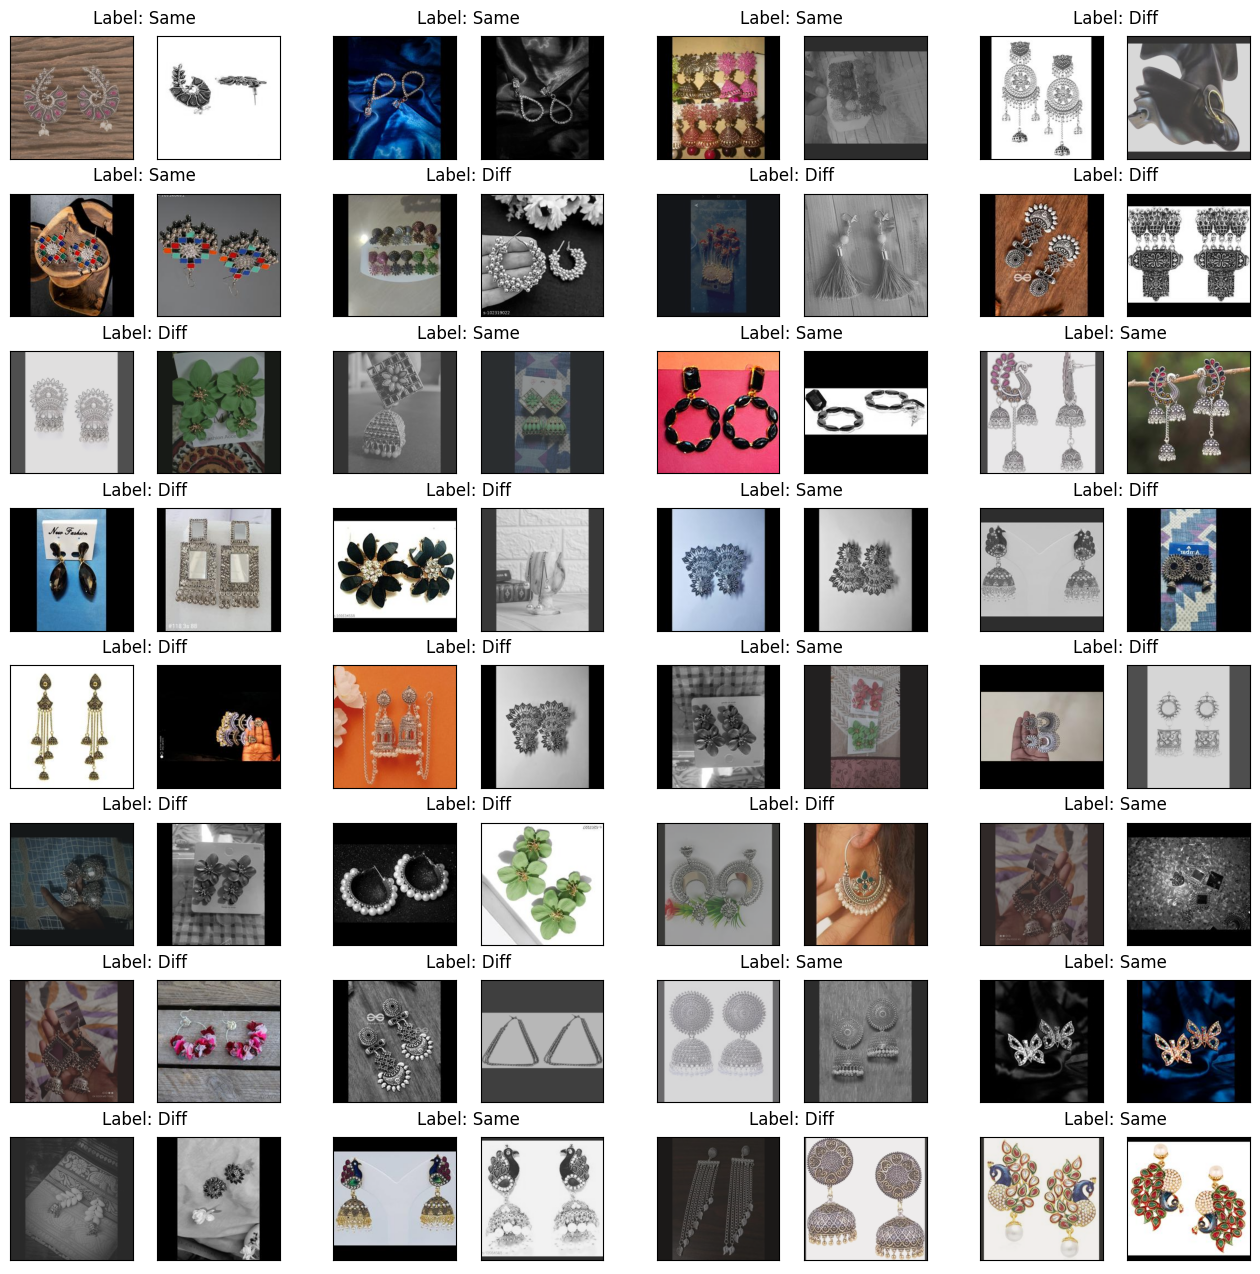

In [8]:
peek_pairs(training_dataset)

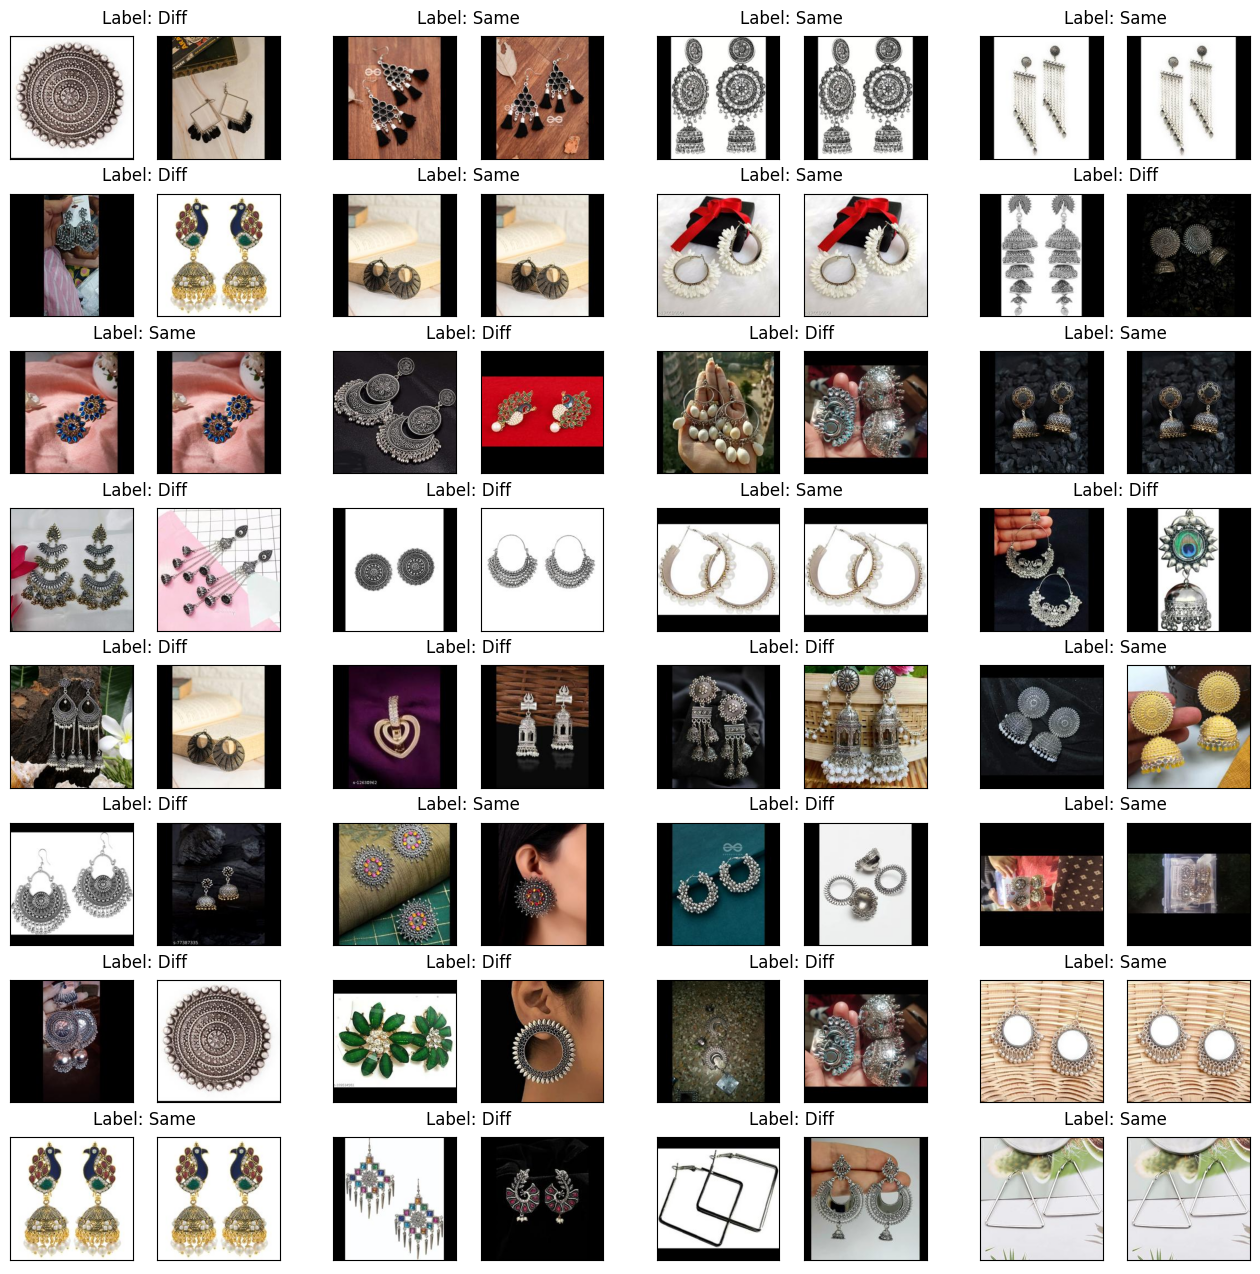

In [9]:
peek_pairs(validation_dataset)

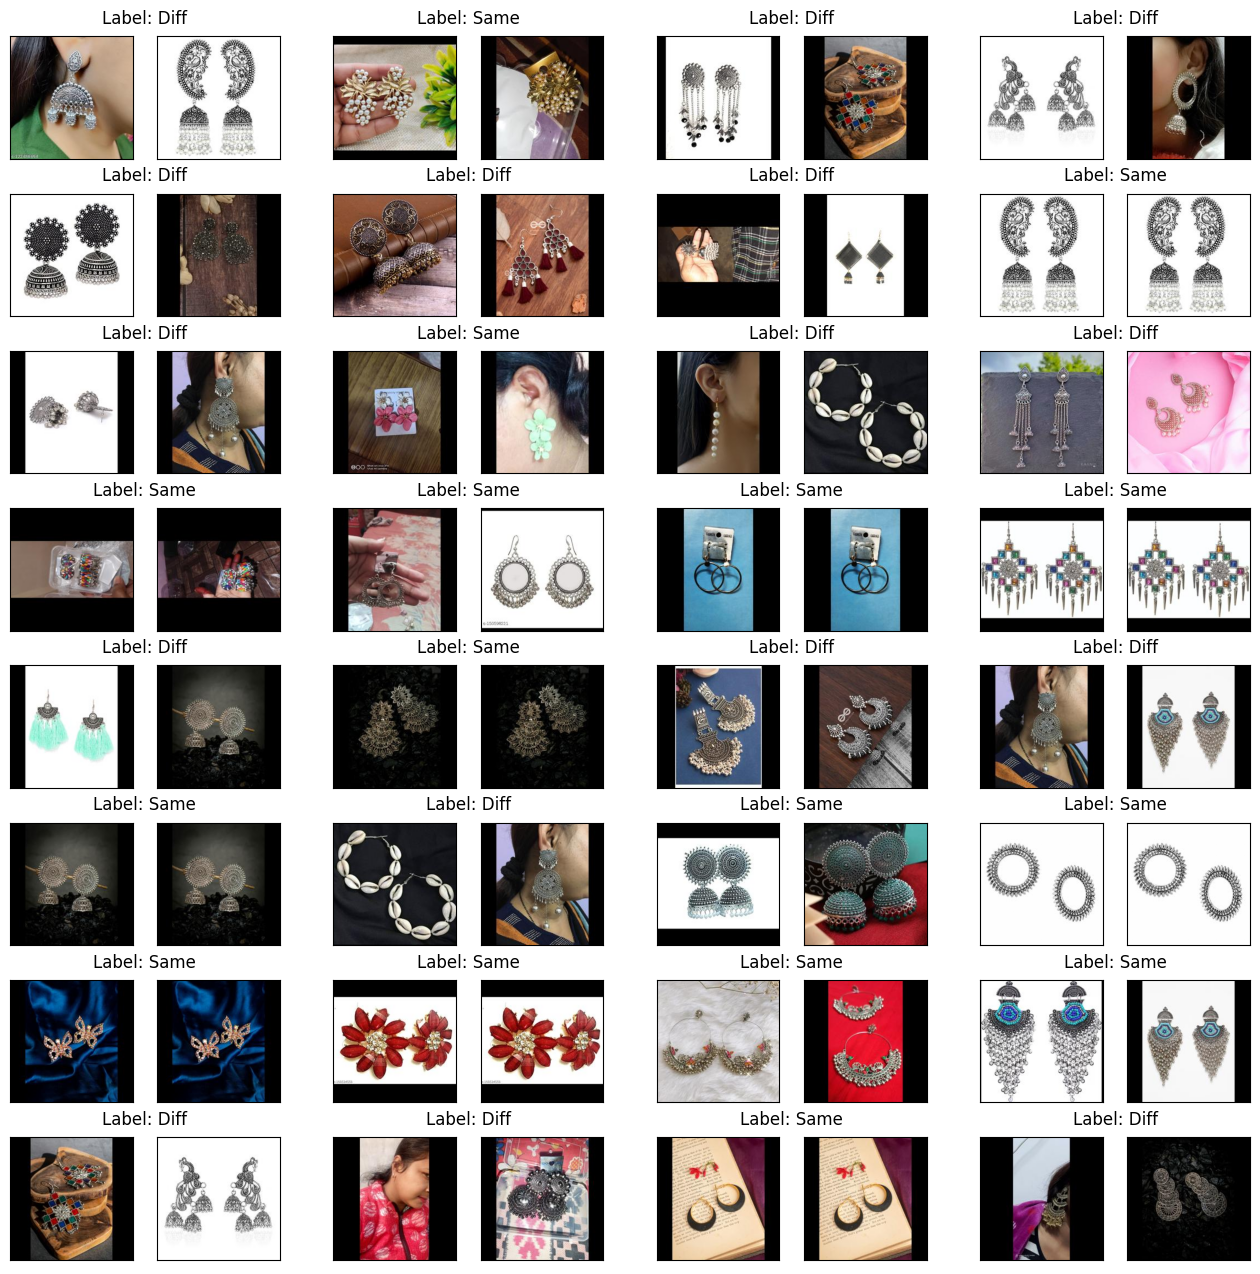

In [10]:
peek_pairs(testing_dataset)

## 3. Build Model


In [11]:
from tensorflow.keras import Model, layers, optimizers, models, callbacks, applications
import tensorflow_hub as hub


class L1_layer(Model):
    def __init__(self, **kwargs):
        super(L1_layer, self).__init__(**kwargs)

    def call(self, tensors):
        x, y = tensors
        distance = tf.math.abs(x - y)
        return distance


def contrastive_loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """
    Computes the contrastive loss for Siamese networks.

    Parameters:
    - y_true: True binary labels (0 for dissimilar pairs, 1 for similar pairs).
    - y_pred: Predicted similarity scores from the Siamese network.

    Returns:
    - Contrastive loss value.

    The contrastive loss penalizes dissimilar pairs that are closer than a margin,
    and encourages similar pairs to be within the margin.
    """
    margin = 1
    y_true = tf.cast(y_true, tf.float32)

    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))

    loss = tf.reduce_mean((1 - y_true) * square_pred + y_true * margin_square)

    return loss


def build_feature_extractor(build_model=BUILD_MODEL, version=VERSION_TAG, feature_size=1024):
    if not build_model:
        return models.load_model(f'{DEVELOPMENT_MODEL_PATH}/feature-extractor-v{version}.keras')

    input_layer = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    feature_extractor = applications.mobilenet_v2.MobileNetV2(
        input_shape=(DIMENSIONS, DIMENSIONS, 3),
        include_top=False,
        weights='imagenet'
    )
    feature_extractor.trainable = True
    # feature_extractor = hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5', trainable=True)(input_layer)
    # flatten_layer = layers.Flatten()(feature_extractor)
    feature_extractor = feature_extractor(input_layer, training=True)
    flatten_layer = layers.GlobalAveragePooling2D()(feature_extractor)
    output_layer = layers.Dense(
        feature_size, activation='sigmoid')(flatten_layer)

    return Model(inputs=input_layer, outputs=output_layer, name="feature_extractor")


def build_discriminator(build_model=BUILD_MODEL, version=VERSION_TAG, feature_size=1024):
    if not build_model:
        return models.load_model(f'{DEVELOPMENT_MODEL_PATH}/discriminator-v{version}.keras')

    input_layer_anchor = layers.Input(shape=(feature_size))
    input_layer_comparator = layers.Input(shape=(feature_size))

    distance_layer = L1_layer()([input_layer_anchor, input_layer_comparator])
    dropout_layer = layers.Dropout(0.2)(distance_layer)
    hidden_layer = layers.Dense(8, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.2)(hidden_layer)
    output_layer = layers.Dense(1, activation='sigmoid')(dropout_layer)

    return Model([input_layer_anchor, input_layer_comparator], outputs=output_layer, name=f"discriminator")


feature_extractor_model = build_feature_extractor()
discriminator_model = build_discriminator()


def build_model():
    input_layer_anchor = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))
    input_layer_comparator = layers.Input(shape=(DIMENSIONS, DIMENSIONS, 3))

    feature_layer_anchor = feature_extractor_model(input_layer_anchor)
    feature_layer_comparator = feature_extractor_model(input_layer_comparator)

    output_layer = discriminator_model(
        [feature_layer_anchor, feature_layer_comparator])

    model = Model(inputs=[input_layer_anchor, input_layer_comparator],
                  outputs=output_layer, name="oneshot-classifier")

    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
    model.compile(optimizer=optimizer, loss=contrastive_loss, metrics=['accuracy'])

    return model


model = build_model()
model.summary()



Model: "oneshot-classifier"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 feature_extractor (Functio  (None, 1024)                 3569728   ['input_5[0][0]',             
 nal)                                                                'input_6[0][0]']             
                                                                                                  
 discriminator (Functional)  (None, 1)                    8209      ['feature_e

## 4. Train Model


In [12]:
# Define the step decay function
def step_decay(epoch):
    epoch += 0
    if epoch < 10:
        initial_lr = 3e-05
        return initial_lr
    elif epoch < 30:
        initial_lr = 1e-05
        return initial_lr
    elif epoch < 40:
        initial_lr = 3e-06
        return initial_lr
    else:
        initial_lr = 1e-06
        return initial_lr


# Define the learning rate schedule
lr_schedule = callbacks.LearningRateScheduler(step_decay)

In [13]:
%%time

from tensorflow.keras import callbacks

CHECKPOINT_MODEL_PATH = f"{ROOT_PATH}/model/checkpoint/siamese"

checkpoint_callback = callbacks.ModelCheckpoint(filepath=CHECKPOINT_MODEL_PATH, 
                                              monitor="val_loss", 
                                              save_best_only=True, 
                                              save_weights_only=False,
                                              mode="min",
                                              save_freq="epoch",
                                              initial_value_threshold=None,
                                              verbose=1)
# Train the model
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset,  callbacks=[lr_schedule, checkpoint_callback])


Epoch 1/10


    100/Unknown - 358s 3s/step - loss: 0.2491 - accuracy: 0.5272
Epoch 1: val_loss improved from inf to 0.24487, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 541s 5s/step - loss: 0.2491 - accuracy: 0.5272 - val_loss: 0.2449 - val_accuracy: 0.5731 - lr: 3.0000e-05
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.2418 - accuracy: 0.5841
Epoch 2: val_loss improved from 0.24487 to 0.23838, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 482s 5s/step - loss: 0.2418 - accuracy: 0.5841 - val_loss: 0.2384 - val_accuracy: 0.5578 - lr: 3.0000e-05
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.6216
Epoch 3: val_loss improved from 0.23838 to 0.22891, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 460s 5s/step - loss: 0.2326 - accuracy: 0.6216 - val_loss: 0.2289 - val_accuracy: 0.6350 - lr: 3.0000e-05
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.6775
Epoch 4: val_loss improved from 0.22891 to 0.21676, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 379s 4s/step - loss: 0.2163 - accuracy: 0.6775 - val_loss: 0.2168 - val_accuracy: 0.6809 - lr: 3.0000e-05
Epoch 5/10
100/100 [==============================] - ETA: 0s - loss: 0.1998 - accuracy: 0.7262
Epoch 5: val_loss improved from 0.21676 to 0.20622, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 360s 4s/step - loss: 0.1998 - accuracy: 0.7262 - val_loss: 0.2062 - val_accuracy: 0.7475 - lr: 3.0000e-05
Epoch 6/10
100/100 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.7675
Epoch 6: val_loss improved from 0.20622 to 0.19054, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 383s 4s/step - loss: 0.1815 - accuracy: 0.7675 - val_loss: 0.1905 - val_accuracy: 0.7950 - lr: 3.0000e-05
Epoch 7/10
100/100 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.7906
Epoch 7: val_loss improved from 0.19054 to 0.18557, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 402s 4s/step - loss: 0.1652 - accuracy: 0.7906 - val_loss: 0.1856 - val_accuracy: 0.8044 - lr: 3.0000e-05
Epoch 8/10
100/100 [==============================] - ETA: 0s - loss: 0.1596 - accuracy: 0.7956
Epoch 8: val_loss improved from 0.18557 to 0.17996, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 412s 4s/step - loss: 0.1596 - accuracy: 0.7956 - val_loss: 0.1800 - val_accuracy: 0.8094 - lr: 3.0000e-05
Epoch 9/10
100/100 [==============================] - ETA: 0s - loss: 0.1450 - accuracy: 0.8247
Epoch 9: val_loss improved from 0.17996 to 0.17276, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 437s 4s/step - loss: 0.1450 - accuracy: 0.8247 - val_loss: 0.1728 - val_accuracy: 0.8103 - lr: 3.0000e-05
Epoch 10/10
100/100 [==============================] - ETA: 0s - loss: 0.1300 - accuracy: 0.8475
Epoch 10: val_loss improved from 0.17276 to 0.16327, saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese
INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


INFO:tensorflow:Assets written to: D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\siamese\assets


100/100 [==============================] - 392s 4s/step - loss: 0.1300 - accuracy: 0.8475 - val_loss: 0.1633 - val_accuracy: 0.8259 - lr: 3.0000e-05
CPU times: total: 4h 54min 15s
Wall time: 1h 10min 48s


### 4.2 Training Result



initial | Training loss: 0.2491 | Validation Loss: 0.2449 || Training Accuracy: 52.72 % | Validation Accuracy: 57.31 %
 latest | Training loss: 0.1300 | Validation Loss: 0.1633 || Training Accuracy: 84.75 % | Validation Accuracy: 82.59 %


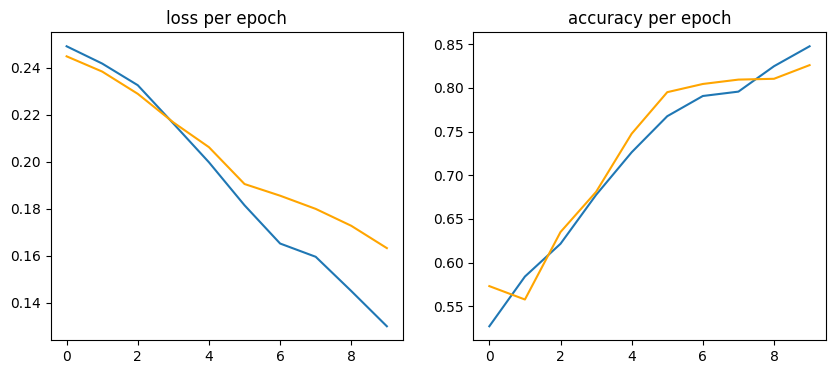

In [14]:
# access metrics from training history
print("\ninitial | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][0], history.history["val_loss"][0], history.history["accuracy"][0] * 100, history.history["val_accuracy"][0] * 100))
print(" latest | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][-1], history.history["val_loss"][-1], history.history["accuracy"][-1] * 100, history.history["val_accuracy"][-1] * 100))

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
# plot loss
axis[0].plot(history.history["loss"])
axis[0].plot(history.history["val_loss"], color='orange')
axis[0].set_title("loss per epoch")
# plot accuracy
axis[1].plot(history.history["accuracy"])
axis[1].plot(history.history["val_accuracy"], color='orange')
axis[1].set_title("accuracy per epoch")
plt.show()

## 5. Test Model


In [15]:
# Evaluate the model
test_loss, test_acc = model.evaluate(testing_dataset)

print('Test loss:', test_loss, 'Test accuracy:', test_acc)

100/100 [==============================] - 125s 1s/step - loss: 0.1627 - accuracy: 0.8384
Test loss: 0.16266770660877228 Test accuracy: 0.8384374976158142


## 6. Visualize Result


In [16]:
test_images = tf.convert_to_tensor([preprocess_image(item, False) for sublist in grouped_testing_dataset.values() for item in sublist])
features = feature_extractor_model.predict(test_images)
test_labels = tf.cast([key for key in grouped_testing_dataset.keys() for item in grouped_testing_dataset[key]], tf.int32).numpy()

8/8 [==============================] - 6s 558ms/step


In [17]:
import json
from collections import Counter

print("Features Tensor:", features.shape)
grouped_features = {}

occurrences = Counter(test_labels)
min_features = min(occurrences.values())

for label, feature in zip(test_labels, features):
    if label in grouped_features:
      if len(grouped_features[label]) < min_features:
        grouped_features[label].append(feature.tolist())
    else:
       grouped_features[label] = [feature.tolist()]

with open("features.json", 'w') as json_file:
    json.dump(list(grouped_features.values()), json_file)

print(f"Averaged Tensor has been dumped to {'features.json'}.")

Features Tensor: (232, 1024)
Averaged Tensor has been dumped to features.json.


In [28]:
# similarity_matrix = calculate_similarity_matrix(features)

anchor_embeddings = features
anchor_class_labels = test_labels

target_embeddings = anchor_embeddings
anchor_embeddings = anchor_embeddings

target_embeddings = tf.expand_dims(target_embeddings, axis=1)
target_embeddings = tf.repeat(target_embeddings, repeats=len(anchor_embeddings), axis=1)
anchor_embeddings = tf.repeat(anchor_embeddings[None, ...], repeats=target_embeddings.shape[0], axis=0)

similarities = discriminator_model.predict((tf.reshape(target_embeddings, [-1, target_embeddings.shape[-1]]),
                                                      tf.reshape(anchor_embeddings, [-1, anchor_embeddings.shape[-1]])))
similarity_matrix = tf.reshape(similarities, [target_embeddings.shape[0], -1]).numpy()

print("Similarity Matrix Shape", similarity_matrix.shape)

1682/1682 [==============================] - 2s 1ms/step
Similarity Matrix Shape (232, 232)


In [33]:
avg_similarity_matrix, avg_test_labels = avg_matrix(similarity_matrix, test_labels)

test_accuracy = oneshot_accuracy(similarity_matrix, test_labels)
avg_test_accuracy = oneshot_accuracy(avg_similarity_matrix, avg_test_labels)

print("Accuracy", test_accuracy, "Class Accuracy", avg_test_accuracy)

Accuracy 0.10775862 Class Accuracy 0.006993007


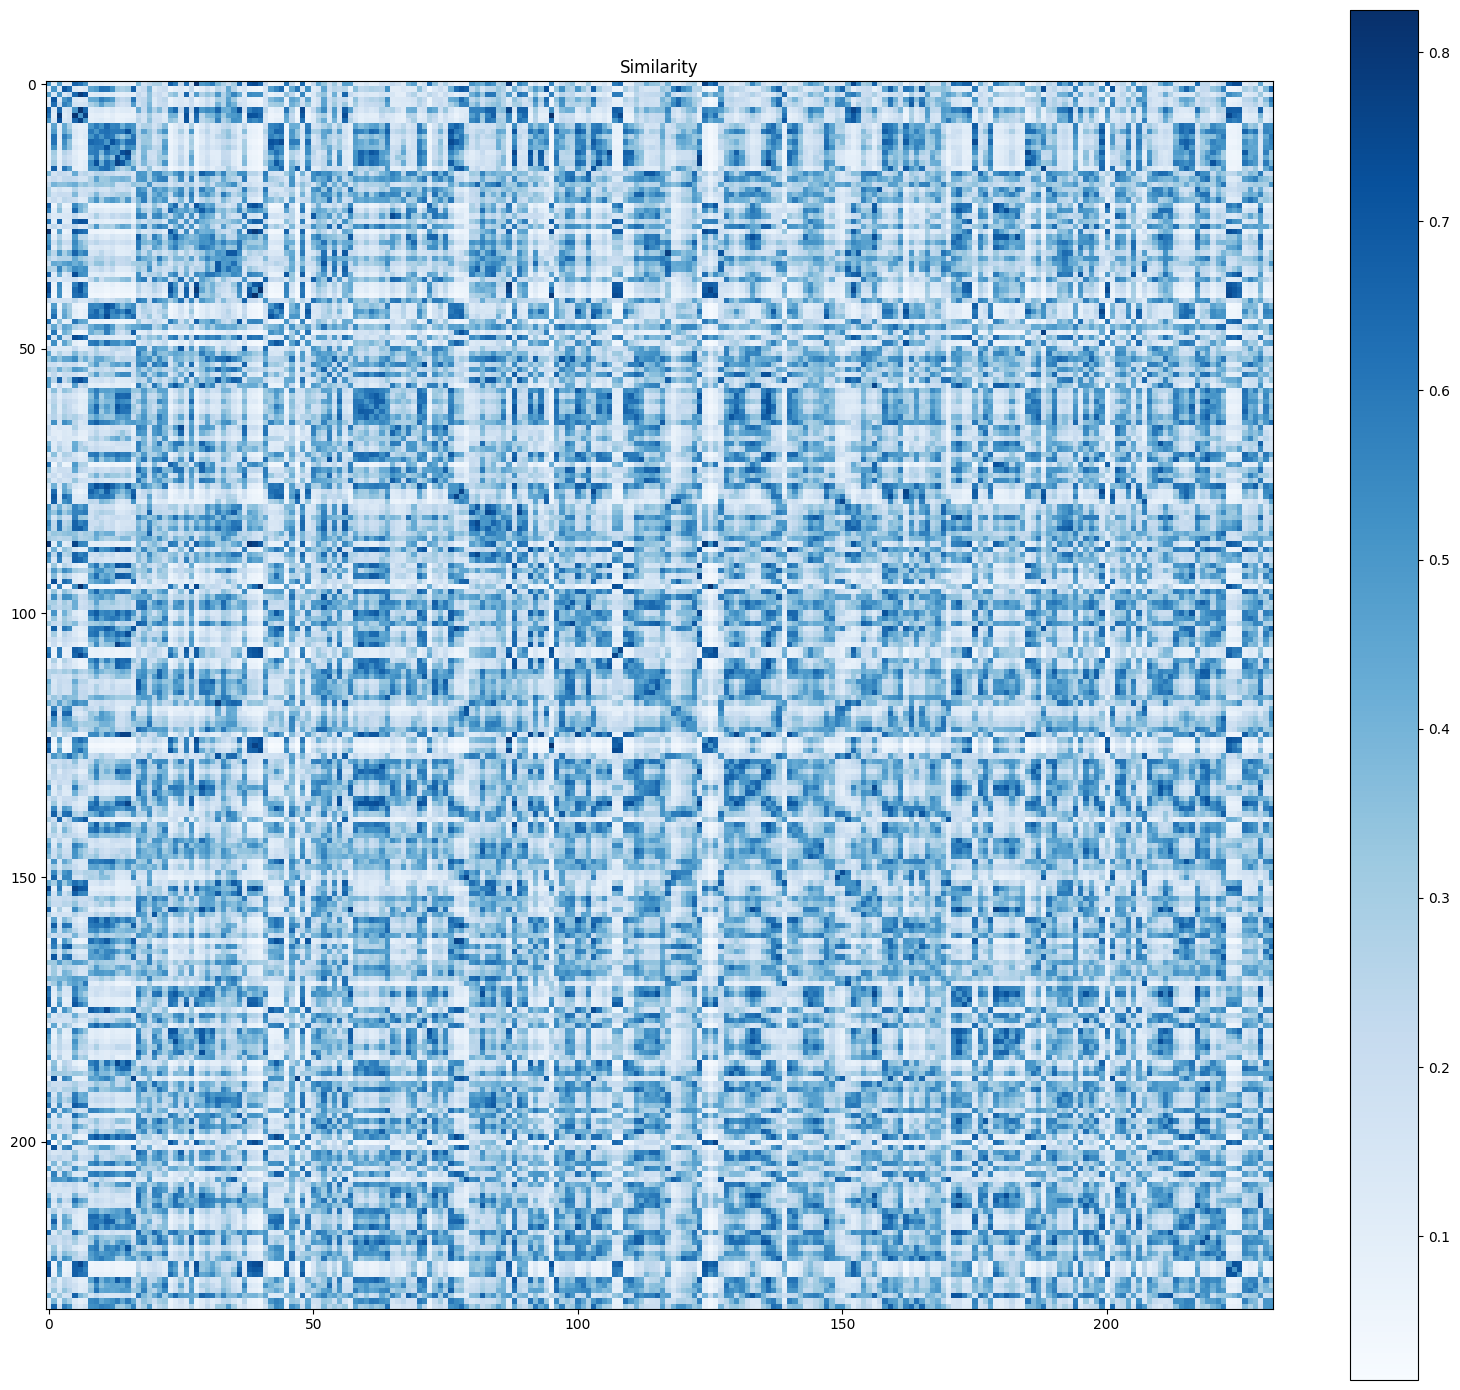

In [34]:
plot_confusion_matrix(similarity_matrix, test_labels, normalize=True, simple=True, title="Similarity")

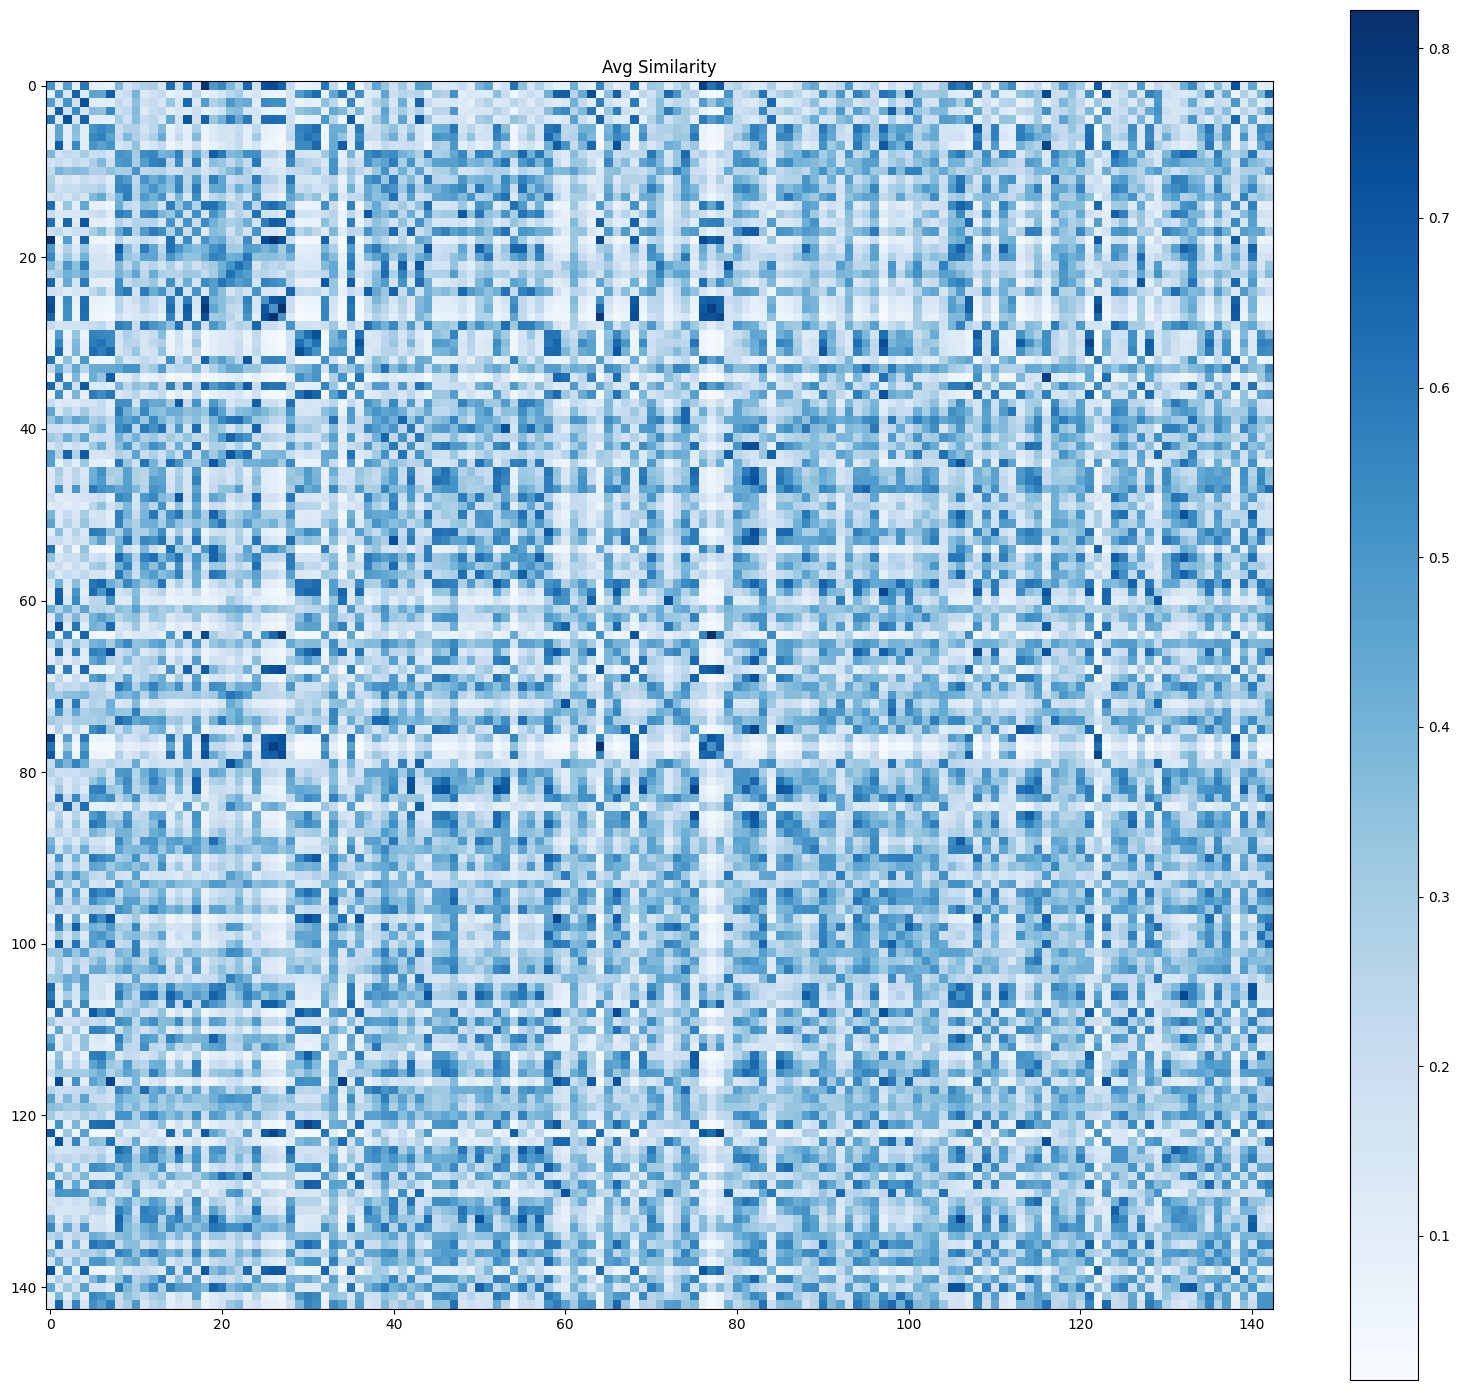

In [35]:
plot_confusion_matrix(avg_similarity_matrix, data_classes, normalize=True, simple=True, title="Avg Similarity")

## 7. Save Model


In [ ]:
VERSION_TAG = input("Enter Version Tag (e.g 0.0.0):") + f"-{int(test_acc * 100)}" if BUILD_MODEL else VERSION_TAG  # "0.0.0"

models.save_model(feature_extractor_model, f'{DEVELOPMENT_MODEL_PATH}/feature-extractor-v{VERSION_TAG}.keras', save_format="keras")
models.save_model(discriminator_model, f'{DEVELOPMENT_MODEL_PATH}/discriminator-v{VERSION_TAG}.keras', save_format="keras")

models.save_model(feature_extractor_model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")
# models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.keras', save_format="keras")
# models.save_model(model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}', save_format="tf")